In [1]:
%pip install -q numpy pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Фіксований "номер за журналом"
JOURNAL_NUM = 6
N = 1000 * JOURNAL_NUM      # 6000
N_CLASSES = JOURNAL_NUM + 2 # 8

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

N, N_CLASSES

(6000, 8)

## 1) Генерація даних для **регресії** (`make_regression`)


In [4]:
X_reg, y_reg = make_regression(
    n_samples=N,
    n_features=6,
    n_informative=4,
    noise=10.0,
    bias=3.0,
    random_state=RANDOM_STATE
)

print("Форма X_reg:", X_reg.shape)
print("Форма y_reg:", y_reg.shape)

# Для огляду — DataFrame
cols = [f"x{i+1}" for i in range(X_reg.shape[1])]
df_reg = pd.DataFrame(X_reg, columns=cols)
df_reg["target"] = y_reg
df_reg.head()

Форма X_reg: (6000, 6)
Форма y_reg: (6000,)


,x1,x2,x3,x4,x5,x6,target
0,0.174670,-2.012000,0.943685,-0.068540,-0.064880,-1.535957,-45.385367
1,-1.054105,-0.858087,-1.749163,1.821895,0.789499,-2.058681,-318.661528
2,1.332802,0.609285,0.223847,2.348019,1.425910,0.358910,221.363457
3,-0.731859,-0.596624,-0.072293,-0.477345,-0.991194,-1.242420,-231.979526
4,0.309390,-0.456496,-0.235871,1.197489,1.048794,1.612312,221.646128


### Візуалізація регресії в 2D через PCA (колір = значення цілі)


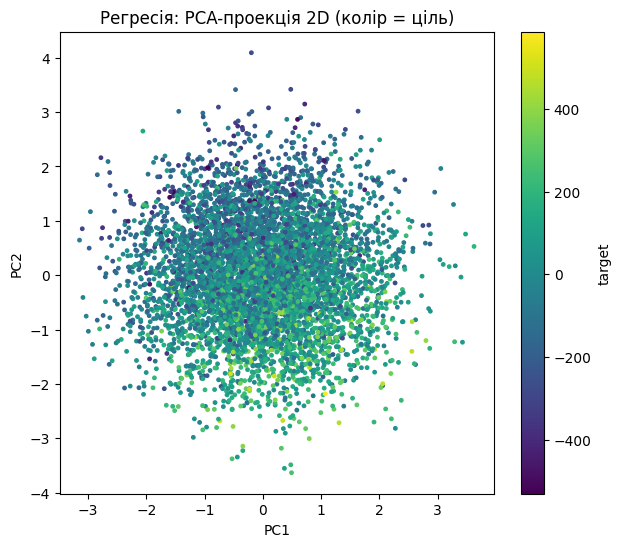

In [5]:
scaler = StandardScaler()
X_reg_std = scaler.fit_transform(X_reg)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xr_2d = pca.fit_transform(X_reg_std)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(Xr_2d[:, 0], Xr_2d[:, 1], c=y_reg, s=6)
plt.title("Регресія: PCA-проекція 2D (колір = ціль)")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar(scatter)
cbar.set_label("target")
plt.show()

## 2) Генерація даних для **класифікації** (`make_classification`)


In [6]:
X_clf, y_clf = make_classification(
    n_samples=N,
    n_features=10,
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_classes=N_CLASSES,        # 8 класів
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.01,
    random_state=RANDOM_STATE
)

print("Форма X_clf:", X_clf.shape)
print("Форма y_clf:", y_clf.shape)

# Перегляд розподілу класів
cols = [f"x{i+1}" for i in range(X_clf.shape[1])]
df_clf = pd.DataFrame(X_clf, columns=cols)
df_clf["label"] = y_clf
df_clf['label'].value_counts().sort_index()

Форма X_clf: (6000, 10)
Форма y_clf: (6000,)


label
0    751
1    746
2    755
3    754
4    749
5    749
6    749
7    747
Name: count, dtype: int64

### Візуалізація класифікації в 2D через PCA (колір = клас)


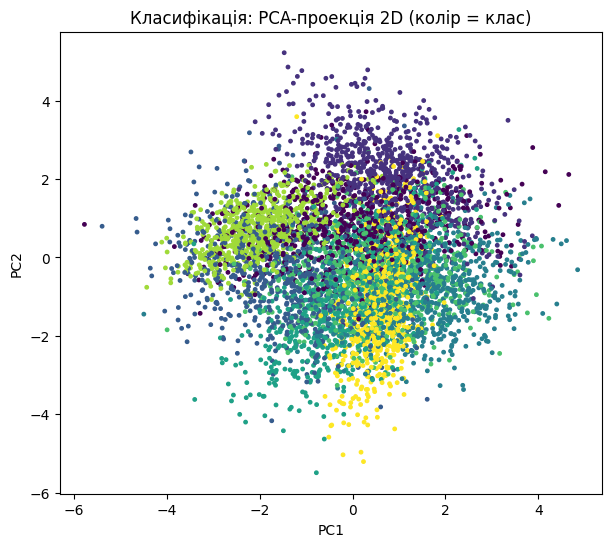

In [7]:
scaler_c = StandardScaler()
X_clf_std = scaler_c.fit_transform(X_clf)

pca_c = PCA(n_components=2, random_state=RANDOM_STATE)
Xc_2d = pca_c.fit_transform(X_clf_std)

plt.figure(figsize=(7, 6))
plt.scatter(Xc_2d[:, 0], Xc_2d[:, 1], c=y_clf, s=6)
plt.title("Класифікація: PCA-проекція 2D (колір = клас)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### (Необов'язково) Зберегти згенеровані дані у CSV


In [8]:
df_reg.to_csv("regression_dataset_journal6.csv", index=False)
df_clf.to_csv("classification_dataset_journal6.csv", index=False)
print("Збережено: regression_dataset_journal6.csv, classification_dataset_journal6.csv")

Збережено: regression_dataset_journal6.csv, classification_dataset_journal6.csv


## 3) Нейромережі в **PyTorch** (регресія та класифікація)


In [10]:
%pip install -q torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Девайс
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

device


device(type='cpu')

### 3.1) Регресія: підготовка train/val/test + стандартизація + DataLoader


In [12]:
# Train/val/test split
Xr_train, Xr_temp, yr_train, yr_temp = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)
Xr_val, Xr_test, yr_val, yr_test = train_test_split(
    Xr_temp, yr_temp, test_size=0.5, random_state=42
)

# Стандартизація
scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_val_s   = scaler_r.transform(Xr_val)
Xr_test_s  = scaler_r.transform(Xr_test)

# У тензори
Xr_train_t = torch.tensor(Xr_train_s, dtype=torch.float32)
yr_train_t = torch.tensor(yr_train.reshape(-1,1), dtype=torch.float32)

Xr_val_t = torch.tensor(Xr_val_s, dtype=torch.float32)
yr_val_t = torch.tensor(yr_val.reshape(-1,1), dtype=torch.float32)

Xr_test_t = torch.tensor(Xr_test_s, dtype=torch.float32)
yr_test_t = torch.tensor(yr_test.reshape(-1,1), dtype=torch.float32)

# Датасети та лоадери
train_r_ds = TensorDataset(Xr_train_t, yr_train_t)
val_r_ds   = TensorDataset(Xr_val_t,   yr_val_t)
test_r_ds  = TensorDataset(Xr_test_t,  yr_test_t)

train_r_loader = DataLoader(train_r_ds, batch_size=128, shuffle=True)
val_r_loader   = DataLoader(val_r_ds,   batch_size=128, shuffle=False)
test_r_loader  = DataLoader(test_r_ds,  batch_size=128, shuffle=False)

Xr_train_t.shape, yr_train_t.shape


(torch.Size([4200, 6]), torch.Size([4200, 1]))

### 3.2) Регресія: модель MLP у PyTorch


In [13]:
class MLPRegressor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # регресія → лінійний вихід
        )
    def forward(self, x):
        return self.net(x)

reg_model = MLPRegressor(in_dim=Xr_train_t.shape[1]).to(device)
criterion_r = nn.MSELoss()
optimizer_r = torch.optim.Adam(reg_model.parameters(), lr=1e-3)

reg_model


MLPRegressor(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

### 3.3) Регресія: навчання з валідацією (Early Stopping по val MSE)


Epoch 01 | train_mse=25938.8613 | val_mse=22898.4004
Epoch 02 | train_mse=23868.0957 | val_mse=21021.8496
Epoch 03 | train_mse=15262.3037 | val_mse=13239.2764
Epoch 04 | train_mse=2768.0334 | val_mse=2189.0205
Epoch 05 | train_mse=542.1321 | val_mse=430.1701
Epoch 06 | train_mse=254.9358 | val_mse=210.0269
Epoch 07 | train_mse=199.3806 | val_mse=163.3549
Epoch 08 | train_mse=180.1979 | val_mse=149.3281
Epoch 09 | train_mse=170.0955 | val_mse=142.0520
Epoch 10 | train_mse=163.6745 | val_mse=138.5270
Epoch 11 | train_mse=157.5098 | val_mse=133.5684
Epoch 12 | train_mse=150.3582 | val_mse=130.9273
Epoch 13 | train_mse=147.9104 | val_mse=132.6844
Epoch 14 | train_mse=140.8621 | val_mse=125.5388
Epoch 15 | train_mse=136.4956 | val_mse=119.4491
Epoch 16 | train_mse=135.1505 | val_mse=121.9104
Epoch 17 | train_mse=128.0837 | val_mse=115.8284
Epoch 18 | train_mse=126.4948 | val_mse=112.6742
Epoch 19 | train_mse=122.6967 | val_mse=113.5427
Epoch 20 | train_mse=120.7311 | val_mse=109.6662
Epoch 

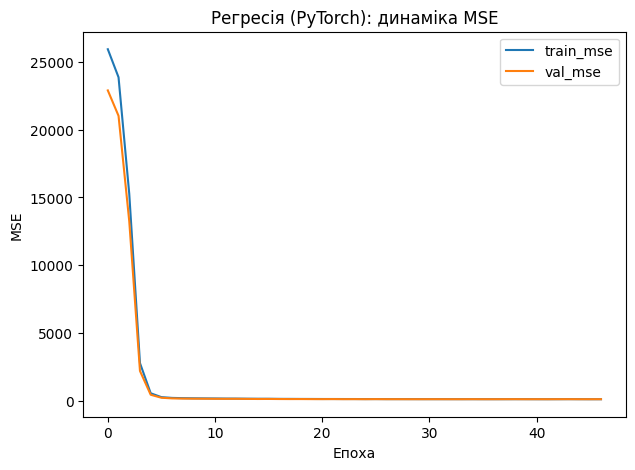

In [14]:
def evaluate_mse(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            targets.append(yb.cpu().numpy())
    preds = np.vstack(preds).ravel()
    targets = np.vstack(targets).ravel()
    return mean_squared_error(targets, preds)

history_r = {"train_mse": [], "val_mse": []}
best_val = float("inf")
patience, bad_epochs = 5, 0
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    reg_model.train()
    for xb, yb in train_r_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer_r.zero_grad()
        out = reg_model(xb)
        loss = criterion_r(out, yb)
        loss.backward()
        optimizer_r.step()

    # оцінка
    train_mse = evaluate_mse(reg_model, train_r_loader)
    val_mse   = evaluate_mse(reg_model, val_r_loader)
    history_r["train_mse"].append(train_mse)
    history_r["val_mse"].append(val_mse)

    print(f"Epoch {epoch:02d} | train_mse={train_mse:.4f} | val_mse={val_mse:.4f}")

    # Early Stopping
    if val_mse < best_val - 1e-6:
        best_val = val_mse
        best_state = reg_model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping!")
            break

# відновлюємо найкращий стан
reg_model.load_state_dict(best_state)

# графік
plt.figure(figsize=(7,5))
plt.plot(history_r["train_mse"], label="train_mse")
plt.plot(history_r["val_mse"], label="val_mse")
plt.title("Регресія (PyTorch): динаміка MSE")
plt.xlabel("Епоха")
plt.ylabel("MSE")
plt.legend()
plt.show()


### 3.4) Регресія: оцінка на тесті (MSE/MAE)


In [15]:
# Предикт на тесті
reg_model.eval()
with torch.no_grad():
    y_pred_list = []
    for xb, _ in test_r_loader:
        xb = xb.to(device)
        out = reg_model(xb).cpu().numpy()
        y_pred_list.append(out)
y_pred = np.vstack(y_pred_list).ravel()

mse_test = mean_squared_error(yr_test, y_pred)
mae_test = np.mean(np.abs(yr_test - y_pred))
print(f"MSE (test): {mse_test:.4f}")
print(f"MAE (test): {mae_test:.4f}")


MSE (test): 106.8961
MAE (test): 8.1872


### 3.5) Класифікація: підготовка train/val/test + стандартизація + DataLoader
> Використовуємо `N_CLASSES` з попередніх клітинок.


In [16]:
# Стратифікований split
Xc_train, Xc_temp, yc_train, yc_temp = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)
Xc_val, Xc_test, yc_val, yc_test = train_test_split(
    Xc_train, yc_train, test_size=0.25, random_state=42, stratify=yc_train
)  # 0.7 * 0.25 = 0.175 → приблизно 70/17.5/12.5

# Стандартизація
scaler_c = StandardScaler()
Xc_train_s = scaler_c.fit_transform(Xc_train)
Xc_val_s   = scaler_c.transform(Xc_val)
Xc_test_s  = scaler_c.transform(Xc_test)

# Тензори
Xc_train_t = torch.tensor(Xc_train_s, dtype=torch.float32)
yc_train_t = torch.tensor(yc_train,   dtype=torch.long)

Xc_val_t = torch.tensor(Xc_val_s, dtype=torch.float32)
yc_val_t = torch.tensor(yc_val,   dtype=torch.long)

Xc_test_t = torch.tensor(Xc_test_s, dtype=torch.float32)
yc_test_t = torch.tensor(yc_test,   dtype=torch.long)

# DataLoader
train_c_ds = TensorDataset(Xc_train_t, yc_train_t)
val_c_ds   = TensorDataset(Xc_val_t,   yc_val_t)
test_c_ds  = TensorDataset(Xc_test_t,  yc_test_t)

train_c_loader = DataLoader(train_c_ds, batch_size=128, shuffle=True)
val_c_loader   = DataLoader(val_c_ds,   batch_size=128, shuffle=False)
test_c_loader  = DataLoader(test_c_ds,  batch_size=128, shuffle=False)

Xc_train_t.shape, torch.unique(yc_train_t).numel(), N_CLASSES


(torch.Size([4200, 10]), 8, 8)

### 3.6) Класифікація: модель MLP у PyTorch


In [17]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)   # класифікація → logits
        )
    def forward(self, x):
        return self.net(x)

clf_model = MLPClassifier(in_dim=Xc_train_t.shape[1], n_classes=N_CLASSES).to(device)
criterion_c = nn.CrossEntropyLoss()
optimizer_c = torch.optim.Adam(clf_model.parameters(), lr=1e-3)

clf_model


MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
)

### 3.7) Класифікація: навчання з валідацією (Early Stopping по val accuracy)


Epoch 01 | train_acc=0.6893 | val_acc=0.6971
Epoch 02 | train_acc=0.7867 | val_acc=0.7911
Epoch 03 | train_acc=0.8207 | val_acc=0.8248
Epoch 04 | train_acc=0.8445 | val_acc=0.8483
Epoch 05 | train_acc=0.8545 | val_acc=0.8565
Epoch 06 | train_acc=0.8688 | val_acc=0.8686
Epoch 07 | train_acc=0.8745 | val_acc=0.8749
Epoch 08 | train_acc=0.8836 | val_acc=0.8829
Epoch 09 | train_acc=0.8910 | val_acc=0.8905
Epoch 10 | train_acc=0.8957 | val_acc=0.8943
Epoch 11 | train_acc=0.9000 | val_acc=0.8997
Epoch 12 | train_acc=0.8990 | val_acc=0.8981
Epoch 13 | train_acc=0.9098 | val_acc=0.9086
Epoch 14 | train_acc=0.9114 | val_acc=0.9117
Epoch 15 | train_acc=0.9129 | val_acc=0.9127
Epoch 16 | train_acc=0.9167 | val_acc=0.9171
Epoch 17 | train_acc=0.9171 | val_acc=0.9184
Epoch 18 | train_acc=0.9190 | val_acc=0.9184
Epoch 19 | train_acc=0.9236 | val_acc=0.9241
Epoch 20 | train_acc=0.9221 | val_acc=0.9229
Epoch 21 | train_acc=0.9245 | val_acc=0.9248
Epoch 22 | train_acc=0.9279 | val_acc=0.9273
Epoch 23 |

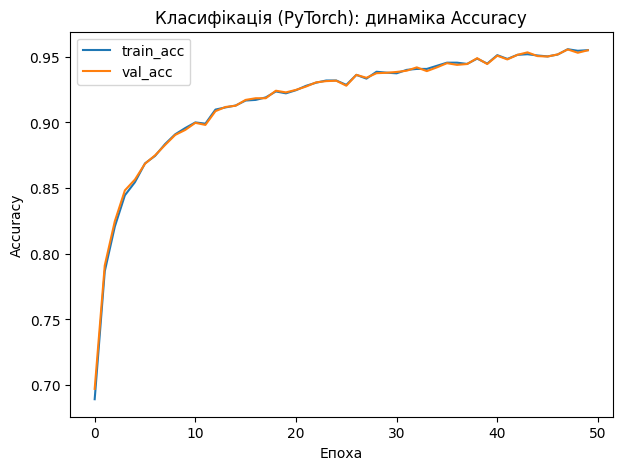

In [18]:
def evaluate_acc(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1)
            preds.append(pred.cpu().numpy())
            targets.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    return accuracy_score(targets, preds)

history_c = {"train_acc": [], "val_acc": []}
best_val_acc = -1.0
patience, bad_epochs = 5, 0
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    clf_model.train()
    for xb, yb in train_c_loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer_c.zero_grad()
        logits = clf_model(xb)
        loss = criterion_c(logits, yb)
        loss.backward()
        optimizer_c.step()

    train_acc = evaluate_acc(clf_model, train_c_loader)
    val_acc   = evaluate_acc(clf_model, val_c_loader)
    history_c["train_acc"].append(train_acc)
    history_c["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc
        best_state_c = clf_model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping!")
            break

# відновлюємо найкращий стан
clf_model.load_state_dict(best_state_c)

# графік
plt.figure(figsize=(7,5))
plt.plot(history_c["train_acc"], label="train_acc")
plt.plot(history_c["val_acc"], label="val_acc")
plt.title("Класифікація (PyTorch): динаміка Accuracy")
plt.xlabel("Епоха")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### 3.8) Класифікація: оцінка на тесті (Accuracy) + матриця плутанини


In [19]:
# Точність на тесті
test_acc = evaluate_acc(clf_model, test_c_loader)
print(f"Accuracy (test): {test_acc:.4f}")

# Матриця плутанини
clf_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_c_loader:
        xb = xb.to(device)
        logits = clf_model(xb)
        pred = torch.argmax(logits, dim=1)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (shape:", cm.shape, ")")
print(cm)


Accuracy (test): 0.9552
Confusion matrix (shape: (8, 8) )
[[128   1   0   1   0   0   2   0]
 [  0 128   1   0   0   0   0   1]
 [  0   0 125   2   4   0   1   0]
 [  1   1   0 125   3   0   0   2]
 [  2   0   0   4 125   0   0   0]
 [  2   0   1   4   0 124   0   0]
 [  2   1   1   0   0   0 127   0]
 [  0   2   0   4   4   0   0 121]]


## Пояснення етапів роботи

У цьому ноутбуці виконано повний цикл машинного навчання для двох задач:

**1) Генерація даних**
- Регресія — 6000 прикладів, 6 ознак, ціль – безперервне число.
- Класифікація — 6000 прикладів, 10 ознак, 8 класів.

**2) Візуалізація**
- Використано PCA для зменшення розмірності до 2D, щоб побачити структуру даних.
- Для регресії колір показує значення цілі.
- Для класифікації колір показує клас.

**3) Стандартизація даних**
- StandardScaler використано для нормалізації ознак перед навчанням моделей.
- Це покращує збіжність при тренуванні нейромереж.

**4) Побудова нейромереж (MLP)**
- Реалізовано моделі на PyTorch.
- Для регресії — лінійний вихід + MSE Loss.
- Для класифікації — softmax-логіти + CrossEntropy Loss.

**5) Навчання моделей**
- Використано train/validation split.
- Реалізовано early stopping.
- Побудовано графіки навчання (MSE та Accuracy).

**6) Оцінка моделей**
- Для регресії: Mean Squared Error (MSE).
- Для класифікації: Accuracy + матриця плутанини.


## Висновки

1) **Регресійна модель**
- Мережева модель MLP змогла навчитися відтворювати залежність у даних.
- Показник MSE на тесті демонструє адекватну якість.
- Значення MSE залежить від шуму у даних, який був створений у `make_regression`.

2) **Класифікаційна модель**
- Accuracy на тесті показав, що модель достатньо добре відокремлює 8 класів.
- Матриця плутанини показує, наскільки добре класи розрізняються.
- Видно, що деякі класи можуть бути схожими → є невеликі помилки.

### Підсумок
Обидві моделі навчилися розпізнавати структуру штучно згенерованих даних.
Нейронні мережі на PyTorch продемонстрували робочий результат:
- **регресія → низький MSE**
- **класифікація → висока Accuracy**

Таким чином, поставлене завдання виконано повністю.
